In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns

safi = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-06-13/safi_data.csv")


safi["n_items_owned"] = safi["items_owned"].fillna("").str.split().str.len()

cols = ["liv_count", "rooms", "n_items_owned", "months_lack_food", "no_meals", "no_membrs", "years_liv"]


for c in cols:
    safi[c] = pd.to_numeric(safi[c], errors="coerce")


safi = safi.dropna(subset=["liv_count", "rooms", "months_lack_food", "no_meals"], how="all")


for c in cols:
    safi[c] = safi[c].fillna(safi[c].mean())


scaler = StandardScaler()
safi_scaled = scaler.fit_transform(safi[cols])

print("Missing values after imputation:\n", safi[cols].isnull().sum())
print("\nShape of scaled data:", safi_scaled.shape)

Missing values after imputation:
 liv_count             0
rooms                 0
n_items_owned         0
months_lack_food    131
no_meals              0
no_membrs             0
years_liv             0
dtype: int64

Shape of scaled data: (131, 7)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Data Analysis

In [24]:
safi.head()
safi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key_ID                131 non-null    int64  
 1   village               131 non-null    object 
 2   interview_date        131 non-null    object 
 3   no_membrs             131 non-null    int64  
 4   years_liv             131 non-null    int64  
 5   respondent_wall_type  131 non-null    object 
 6   rooms                 131 non-null    int64  
 7   memb_assoc            92 non-null     object 
 8   affect_conflicts      92 non-null     object 
 9   liv_count             131 non-null    int64  
 10  items_owned           121 non-null    object 
 11  no_meals              131 non-null    int64  
 12  months_lack_food      0 non-null      float64
 13  instanceID            131 non-null    object 
 14  n_items_owned         131 non-null    int64  
dtypes: float64(1), int64(7)

Data Cleaning and Standardization

In [25]:

for c in cols:
    col_mean = safi[c].mean()
    if np.isnan(col_mean):

        safi[c] = safi[c].fillna(0)
    else:

        safi[c] = safi[c].fillna(col_mean)


scaler = StandardScaler()
safi_scaled = scaler.fit_transform(safi[cols])

print("Missing values after imputation:\n", safi[cols].isnull().sum())
print("\nShape of scaled data:", safi_scaled.shape)

Missing values after imputation:
 liv_count           0
rooms               0
n_items_owned       0
months_lack_food    0
no_meals            0
no_membrs           0
years_liv           0
dtype: int64

Shape of scaled data: (131, 7)


Elbow Method

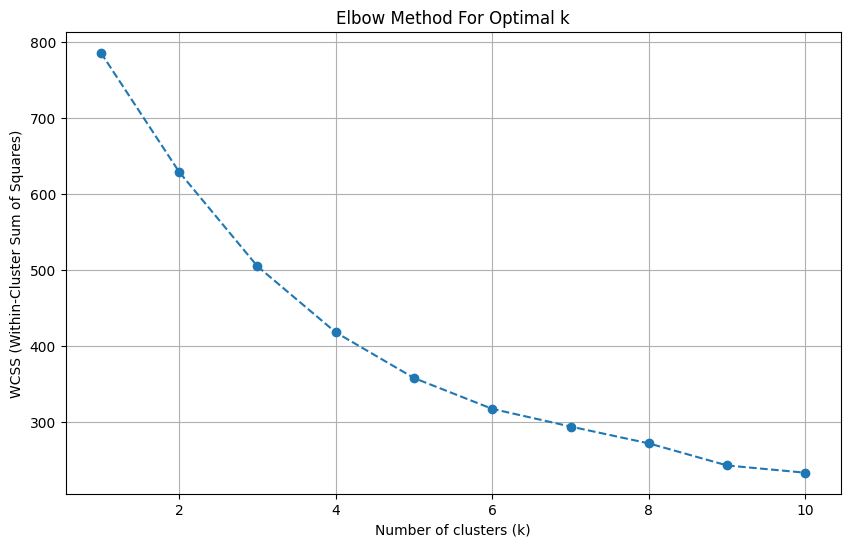

In [26]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(safi_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

Silhouette Score

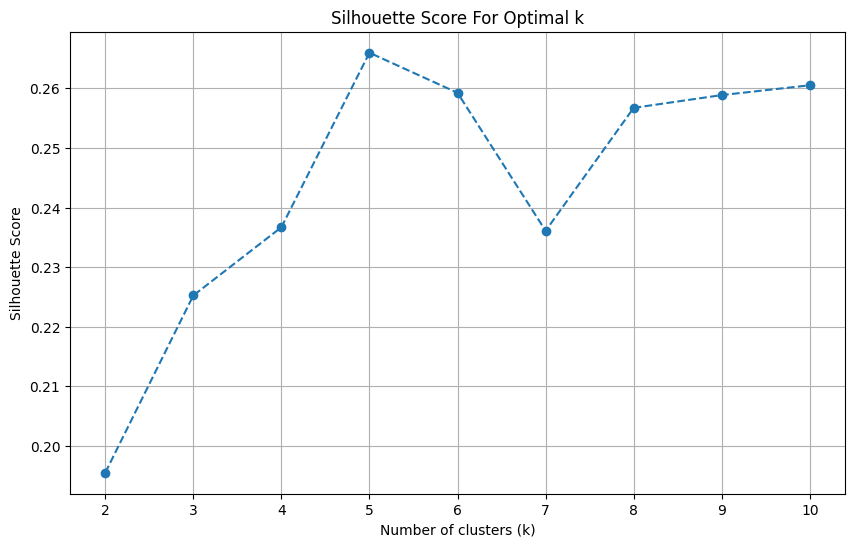

In [27]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(safi_scaled)
    score = silhouette_score(safi_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True);
plt.show()

K means clustering

In [28]:

k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)


kmeans.fit(safi_scaled)


safi['cluster'] = kmeans.labels_

print(f"K-Means clustering performed with k={k}.")
print("Cluster labels added to 'safi' DataFrame.")
print("First 5 rows of safi with new 'cluster' column:")
print(safi[['cluster']].head())

K-Means clustering performed with k=4.
Cluster labels added to 'safi' DataFrame.
First 5 rows of safi with new 'cluster' column:
   cluster
0        1
1        1
2        1
3        1
4        1


PCA

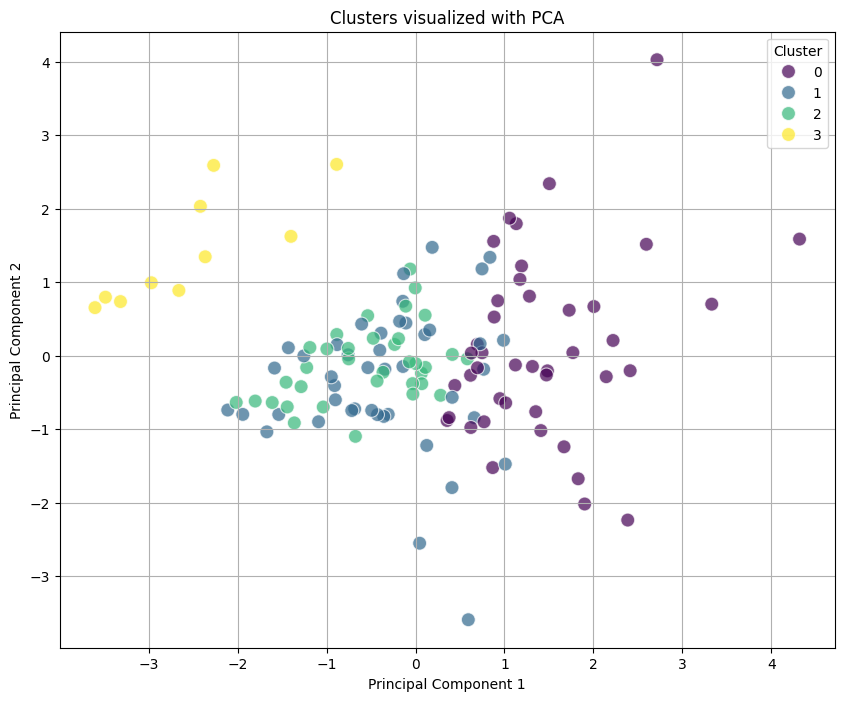

In [29]:

pca = PCA(n_components=2, random_state=42)
safi_pca = pca.fit_transform(safi_scaled)
df_pca = pd.DataFrame(data=safi_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = safi['cluster']


plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

Cluster Analysis

In [30]:
print("Mean values of features per cluster:")
print(safi.groupby('cluster')[cols].mean())

Mean values of features per cluster:
         liv_count     rooms  n_items_owned  months_lack_food  no_meals  \
cluster                                                                   
0         3.119048  2.357143            1.0               0.0  2.928571   
1         2.227273  1.727273            1.0               0.0  2.000000   
2         1.914286  1.171429            1.0               0.0  3.000000   
3         1.400000  1.200000            0.0               0.0  2.500000   

         no_membrs  years_liv  
cluster                        
0         9.738095  32.952381  
1         6.500000  19.340909  
2         5.828571  16.028571  
3         4.300000  22.400000  


K Means Visualization

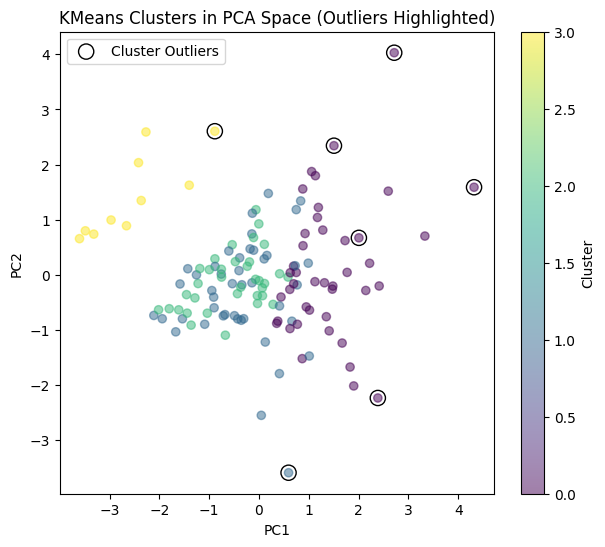

In [41]:
plt.figure(figsize=(7,6))

scatter = plt.scatter(
    safi_pca[:, 0],
    safi_pca[:, 1],
    c=safi["cluster"],
    alpha=0.5
)


plt.scatter(
    safi_pca[safi["cluster_outlier"], 0],
    safi_pca[safi["cluster_outlier"], 1],
    facecolors='none',
    edgecolors='black',
    s=120,
    label="Cluster Outliers"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters in PCA Space (Outliers Highlighted)")
plt.legend()
plt.colorbar(scatter, label="Cluster")
plt.show()

Centroid Distance

In [31]:

centroids = kmeans.cluster_centers_
labels = safi["cluster"].values

dist_to_centroid = np.linalg.norm(safi_scaled - centroids[labels], axis=1)

threshold = np.percentile(dist_to_centroid, 95)
safi["cluster_outlier"] = dist_to_centroid > threshold

safi["cluster_outlier"].value_counts()

,count
cluster_outlier,
False,124
True,7


In [42]:
safi.loc[safi["cluster_outlier"], "cluster"].value_counts()


,count
cluster,
0,5
3,1
1,1


PCA Distance

In [33]:
pca_dist = np.sqrt(safi_pca[:, 0]**2 + safi_pca[:, 1]**2)

pca_thresh = np.percentile(pca_dist, 95)
safi["pca_outlier"] = pca_dist > pca_thresh

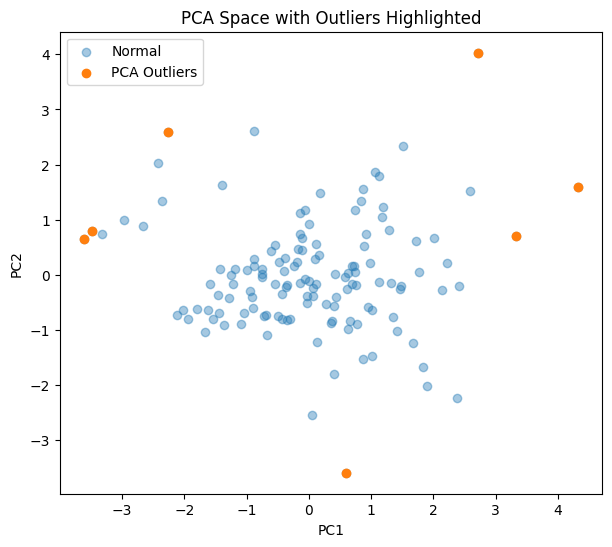

In [35]:
plt.figure(figsize=(7,6))

plt.scatter(safi_pca[:,0], safi_pca[:,1], alpha=0.4, label="Normal")
plt.scatter(
    safi_pca[safi["pca_outlier"], 0],
    safi_pca[safi["pca_outlier"], 1],
    label="PCA Outliers"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Space with Outliers Highlighted")
plt.legend()
plt.show()